In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_5441/3007722094.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/dim_reduced_data.csv')

In [4]:
# -----------------------------
# CONFIG
# -----------------------------
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

In [9]:
def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training: {len(train_data)} rows | Testing: {len(test_data)} rows")
    return train_data, test_data


In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# IMPROVED SARIMA FORECAST FUNCTION WITH ROBUST NaN HANDLING
# -----------------------------
def forecast_with_sarima_robust(train_df, test_df, target, freq='M', auto_tune=True, order=(1,1,1), seasonal_order=(0,0,0,0)):
    print(f"\n{'='*50}")
    print(f"SARIMA Forecasting: {target}")
    print(f"{'='*50}")

    # -----------------------------
    # Check if target exists
    # -----------------------------
    if target not in train_df.columns:
        print(f"❌ Target {target} not found in training data")
        return None, None, None, None, None, None

    # -----------------------------
    # Prepare training and test sets with robust cleaning
    # -----------------------------
    train = train_df[['date', target]].copy()
    train.columns = ['ds', 'y']
    test = test_df[['date', target]].copy()
    test.columns = ['ds', 'y']

    # Step 1: Replace inf values with NaN
    train.replace([np.inf, -np.inf], np.nan, inplace=True)
    test.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Step 2: Convert to numeric (this will create NaN for non-numeric values)
    train['y'] = pd.to_numeric(train['y'], errors='coerce')
    test['y'] = pd.to_numeric(test['y'], errors='coerce')

    # Step 3: Check NaN percentage before cleaning
    train_nan_pct = train['y'].isna().sum() / len(train) * 100
    test_nan_pct = test['y'].isna().sum() / len(test) * 100
    
    print(f"📊 Initial NaN percentages: Train={train_nan_pct:.1f}%, Test={test_nan_pct:.1f}%")

    # Step 4: If too many NaNs, skip this indicator
    if train_nan_pct > 50:
        print(f"❌ Too many NaN values in training data: {train_nan_pct:.1f}%")
        return None, None, None, None, None, None

    # Step 5: First clean the data BEFORE setting datetime index
    # Strategy 1: Forward fill then backward fill
    train['y'] = train['y'].fillna(method='ffill').fillna(method='bfill')
    test['y'] = test['y'].fillna(method='ffill').fillna(method='bfill')
    
    # Strategy 2: If still NaNs, use interpolation
    if train['y'].isna().any():
        print("🔄 Using interpolation to fill remaining NaNs...")
        train['y'] = train['y'].interpolate(method='linear')
        
    if test['y'].isna().any():
        test['y'] = test['y'].interpolate(method='linear')
    
    # Strategy 3: If still NaNs, use mean filling
    if train['y'].isna().any():
        print("🔄 Using mean filling for remaining NaNs...")
        train_mean = train['y'].mean()
        train['y'] = train['y'].fillna(train_mean)
        
    if test['y'].isna().any():
        test_mean = test['y'].mean()
        test['y'] = test['y'].fillna(test_mean)
    
    # Strategy 4: Drop any remaining NaN rows BEFORE setting index
    train_before = len(train)
    test_before = len(test)
    
    train = train.dropna()
    test = test.dropna()
    
    if len(train) < train_before or len(test) < test_before:
        print(f"🔄 Dropped NaN rows: Train {train_before}->{len(train)}, Test {test_before}->{len(test)}")

    # Step 6: Now set datetime index on clean data
    train.set_index('ds', inplace=True)
    test.set_index('ds', inplace=True)

    # Step 7: Handle frequency setting more carefully
    # Don't use asfreq() as it creates NaNs for missing dates
    # Instead, ensure the index is properly sorted
    train = train.sort_index()
    test = test.sort_index()
    
    # Optional: Only set frequency if the data is actually regular
    try:
        # Check if data frequency matches expected frequency
        if len(train) > 1:
            inferred_freq = pd.infer_freq(train.index)
            if inferred_freq == freq:
                train.index.freq = freq
                test.index.freq = freq
                print(f"✅ Set frequency to {freq}")
            else:
                print(f"⚠️ Data frequency ({inferred_freq}) doesn't match expected ({freq}), skipping frequency setting")
    except Exception as e:
        print(f"⚠️ Frequency inference failed: {e}, proceeding without frequency setting")

    # Step 8: Final validation after all cleaning
    if len(train) < 10:
        print(f"❌ Insufficient clean training data: {len(train)} rows")
        return None, None, None, None, None, None
        
    if train['y'].isna().any() or test['y'].isna().any():
        print(f"❌ NaN values still present after all cleaning steps")
        return None, None, None, None, None, None
        
    if not np.isfinite(train['y']).all() or not np.isfinite(test['y']).all():
        print(f"❌ Non-finite values detected after cleaning")
        return None, None, None, None, None, None

    print(f"✅ Final clean data: {len(train)} train, {len(test)} test rows")
    
    # Step 9: Check for sufficient variance
    train_std = train['y'].std()
    if train_std < 1e-10:
        print(f"❌ Training data has no variance (std: {train_std})")
        return None, None, None, None, None, None
    
    print(f"📈 Data statistics: Mean={train['y'].mean():.4f}, Std={train_std:.4f}")

    # -----------------------------
    # Automatically tune SARIMA parameters with anti-flat-forecast measures
    # -----------------------------
    if auto_tune:
        try:
            print("🔄 Auto-tuning SARIMA parameters...")
            m_val = 12 if freq == 'M' else (52 if freq == 'W' else (7 if freq == 'D' else 1))
            
            # More aggressive auto_arima settings to avoid flat forecasts
            auto_model = pm.auto_arima(
                train['y'].values,
                seasonal=True if m_val > 1 else False,
                m=m_val,
                stepwise=True,
                suppress_warnings=True,
                error_action='ignore',
                trace=False,
                maxiter=100,
                max_p=2, max_q=2, max_P=1, max_Q=1,  # Reduced complexity to avoid overfitting
                start_p=0, start_q=0, start_P=0, start_Q=0,
                d=None, D=None,  # Let auto_arima determine differencing
                information_criterion='aic',
                alpha=0.05,
                test='adf',  # Use Augmented Dickey-Fuller test
                seasonal_test='ocsb',
                n_jobs=1
            )
            order = auto_model.order
            seasonal_order = auto_model.seasonal_order
            print(f"✅ Optimal parameters: order={order}, seasonal_order={seasonal_order}")
            
            # Check if auto_arima suggests too much differencing (can cause flat forecasts)
            if order[1] + seasonal_order[1] > 2:
                print(f"⚠️ High differencing detected (d={order[1]}, D={seasonal_order[1]}), trying reduced version")
                # Try with less differencing
                order = (order[0], min(1, order[1]), order[2])
                seasonal_order = (seasonal_order[0], min(1, seasonal_order[1]), seasonal_order[2], seasonal_order[3])
                
        except Exception as e:
            print(f"⚠️ Auto-tuning failed ({str(e)}), using simple defaults")
            order = (1, 1, 1)
            seasonal_order = (0, 0, 0, 0)

    # -----------------------------
    # Fit SARIMA model with anti-flat-forecast configurations
    # -----------------------------
    fitted_model = None
    model_configs = [
        (order, seasonal_order),
        ((1, 0, 1), (0, 0, 0, 0)),  # ARMA without differencing
        ((2, 1, 0), (0, 0, 0, 0)),  # AR(2) with differencing
        ((0, 1, 2), (0, 0, 0, 0)),  # MA(2) with differencing
        ((1, 1, 0), (1, 0, 0, 12)),  # Simple seasonal AR
        ((1, 0, 0), (0, 0, 0, 0))   # Simple AR(1) - often works well
    ]
    
    for i, (config_order, config_seasonal) in enumerate(model_configs):
        try:
            print(f"🔄 Trying SARIMA({config_order[0]},{config_order[1]},{config_order[2]})({config_seasonal[0]},{config_seasonal[1]},{config_seasonal[2]},{config_seasonal[3]}) [Attempt {i+1}]")
            
            model = SARIMAX(
                train['y'].values,
                order=config_order, 
                seasonal_order=config_seasonal,
                enforce_stationarity=False, 
                enforce_invertibility=False,
                simple_differencing=False,  # Use integrated differencing
                initialization='approximate_diffuse'  # Better initialization
            )
            
            fitted_model = model.fit(
                disp=False, 
                maxiter=200,
                method='lbfgs',
                low_memory=True
            )
            
            # Test the model by making a short forecast to check if it's flat
            test_forecast = fitted_model.get_forecast(steps=5)
            test_pred = test_forecast.predicted_mean
            test_std = np.std(test_pred)
            
            print(f"✅ Model fitted successfully")
            print(f"🧪 Test forecast std: {test_std:.6f}")
            
            # If forecast is too flat, try next configuration
            if test_std < 1e-8 and i < len(model_configs) - 1:
                print(f"⚠️ Model produces flat forecasts, trying next configuration...")
                continue
            else:
                break
            
        except Exception as e:
            print(f"⚠️ Configuration failed: {str(e)}")
            continue
    
    if fitted_model is None:
        print(f"❌ All SARIMA configurations failed")
        return None, None, None, None, None, None

    # -----------------------------
    # Generate forecast
    # -----------------------------
    try:
        steps = len(test)
        forecast = fitted_model.get_forecast(steps=steps)
        forecast_values = forecast.predicted_mean
        conf_int = forecast.conf_int()
        
        # Validate forecast
        if not np.isfinite(forecast_values).all():
            print(f"❌ Forecast contains non-finite values")
            return None, None, None, None, None, None
            
    except Exception as e:
        print(f"❌ Forecasting failed: {str(e)}")
        return None, None, None, None, None, None

    # -----------------------------
    # Evaluate performance
    # -----------------------------
    y_true = test['y'].values
    y_pred = forecast_values  # forecast_values is already a numpy array

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    def safe_mape(y_true, y_pred, epsilon=1e-8):
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon))) * 100

    mape = safe_mape(y_true, y_pred)

    # Check forecast quality with enhanced diagnostics
    pred_std = np.std(y_pred)
    pred_range = np.max(y_pred) - np.min(y_pred)
    actual_std = np.std(y_true)
    
    print(f"🔍 Forecast diagnostics:")
    print(f"   • Forecast std: {pred_std:.6f}")
    print(f"   • Forecast range: {pred_range:.6f}")
    print(f"   • Actual test std: {actual_std:.4f}")
    print(f"   • Std ratio (pred/actual): {pred_std/actual_std:.4f}")
    
    if pred_std < 1e-6:
        print(f"❌ WARNING: Forecast is essentially flat (std: {pred_std:.8f})")
        # Don't return None here - let's see the flat forecast for debugging
    elif pred_std / actual_std < 0.01:  # Forecast variation < 1% of actual variation
        print(f"⚠️ WARNING: Forecast variation much smaller than actual variation")
    else:
        print(f"✅ Forecast has reasonable variation")

    print(f"📊 Performance: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%")

    # -----------------------------
    # Prepare results
    # -----------------------------
    # Handle confidence intervals more robustly
    try:
        if hasattr(conf_int, 'values'):
            # conf_int is a DataFrame
            conf_int_values = conf_int.values
        else:
            # conf_int is already a numpy array
            conf_int_values = conf_int
            
        # Check if we have confidence intervals
        if conf_int_values.shape[1] >= 2:
            lower_bound = conf_int_values[:, 0]
            upper_bound = conf_int_values[:, 1]
        else:
            # Fallback: create simple confidence intervals
            lower_bound = y_pred * 0.95
            upper_bound = y_pred * 1.05
            
    except Exception as e:
        print(f"⚠️ Confidence interval handling failed: {e}, using fallback")
        lower_bound = y_pred * 0.95
        upper_bound = y_pred * 1.05

    forecast_df = pd.DataFrame({
        'ds': test.index,
        'yhat': y_pred,
        'yhat_lower': lower_bound,
        'yhat_upper': upper_bound
    }).reset_index(drop=True)

    test_df_result = test.reset_index()

    return fitted_model, forecast_df, mae, rmse, mape, test_df_result

# -----------------------------
# DIAGNOSTIC FUNCTION FOR FLAT FORECASTS
# -----------------------------
def diagnose_flat_forecast(train_data, indicator_name):
    """
    Diagnose potential reasons for flat forecasts
    """
    print(f"\n🔍 DIAGNOSTIC REPORT FOR {indicator_name}")
    print("="*50)
    
    y = train_data['y']
    
    # Basic statistics
    print(f"📊 Basic Statistics:")
    print(f"   • Mean: {y.mean():.6f}")
    print(f"   • Std: {y.std():.6f}")
    print(f"   • Min: {y.min():.6f}")
    print(f"   • Max: {y.max():.6f}")
    print(f"   • Range: {y.max() - y.min():.6f}")
    print(f"   • CV: {y.std() / abs(y.mean()) * 100:.3f}%")
    
    # Check for stationarity
    from statsmodels.tsa.stattools import adfuller
    try:
        adf_result = adfuller(y.dropna())
        print(f"🧪 Stationarity Test (ADF):")
        print(f"   • p-value: {adf_result[1]:.6f}")
        print(f"   • Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")
    except:
        print(f"⚠️ Stationarity test failed")
    
    # Check differencing
    y_diff = y.diff().dropna()
    print(f"📈 First Difference:")
    print(f"   • Std: {y_diff.std():.6f}")
    print(f"   • Mean: {y_diff.mean():.6f}")
    
    # Check for patterns
    n_unique = y.nunique()
    print(f"🔍 Pattern Analysis:")
    print(f"   • Unique values: {n_unique}/{len(y)} ({n_unique/len(y)*100:.1f}%)")
    
    # Check last values (recent trend)
    last_10 = y.tail(10)
    print(f"📉 Recent Trend (last 10 values):")
    print(f"   • Mean: {last_10.mean():.6f}")
    print(f"   • Std: {last_10.std():.6f}")
    print(f"   • Values: {last_10.values}")

# -----------------------------
# PLOTTING FUNCTION (unchanged)
# -----------------------------
def plot_sarima_forecast_detailed(model, forecast, test, target):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(test['ds'], test['y'], label='Actual', color='blue', linewidth=2)
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linewidth=2)
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                    color='pink', alpha=0.3, label='95% CI')
    ax.set_title(f"{target} - SARIMA Forecast vs Actual")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -----------------------------
# UPDATED PIPELINE FUNCTION
# -----------------------------
def run_sarima_pipeline_robust(df, financial_indicators, freq='M', auto_tune=True, plot_results=True):
    """
    Run SARIMA forecasting pipeline with robust error handling
    """
    # Split data into train/test (you'll need to implement prepare_data_split)
    train_data, test_data = prepare_data_split(df)
    all_results = {}

    successful_forecasts = 0
    failed_forecasts = []

    print(f"\n🚀 Starting SARIMA Pipeline for {len(financial_indicators)} indicators")
    print(f"Training: {len(train_data)} rows | Testing: {len(test_data)} rows")

    for i, indicator in enumerate(financial_indicators, 1):
        print(f"\n[{i}/{len(financial_indicators)}] Processing {indicator}")
        
        if indicator not in df.columns:
            print(f"⚠️ {indicator} not found in DataFrame")
            failed_forecasts.append(indicator)
            continue

        try:
            # Use the robust SARIMA function
            result = forecast_with_sarima_robust(
                train_data, test_data, indicator,
                freq=freq, auto_tune=auto_tune
            )

            model, forecast, mae, rmse, mape, test = result

            # Check if forecast is valid and run diagnostics if flat
            if model is not None and forecast is not None:
                # Run diagnostics if forecast appears flat
                forecast_std = np.std(forecast['yhat'])
                if forecast_std < 1e-5:
                    print(f"🔍 Running diagnostics for flat forecast...")
                    diagnose_flat_forecast(train_data[train_data[target].notna()][['date', target]].rename(columns={'date': 'ds', target: 'y'}).set_index('ds'), indicator)
                
                all_results[indicator] = {
                    'model': model,
                    'forecast': forecast,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'test_data': test
                }
                successful_forecasts += 1
                print(f"✅ {indicator} completed successfully")

                # Plot results if requested
                if plot_results:
                    try:
                        plot_sarima_forecast_detailed(model, forecast, test, indicator)
                    except Exception as plot_e:
                        print(f"⚠️ Plotting failed for {indicator}: {plot_e}")
            else:
                print(f"❌ {indicator} forecast failed")
                failed_forecasts.append(indicator)

        except Exception as e:
            print(f"❌ Unexpected error with {indicator}: {str(e)}")
            failed_forecasts.append(indicator)

    # -----------------------------
    # Pipeline summary
    # -----------------------------
    print(f"\n{'='*60}")
    print(f"📈 SARIMA PIPELINE SUMMARY")
    print(f"{'='*60}")
    print(f"✅ Successful forecasts: {successful_forecasts}/{len(financial_indicators)}")
    print(f"❌ Failed forecasts: {len(failed_forecasts)}/{len(financial_indicators)}")
    
    if failed_forecasts:
        print(f"\n❌ Failed indicators:")
        for failed in failed_forecasts:
            print(f"   • {failed}")
    
    if successful_forecasts > 0:
        print(f"\n✅ Successful indicators:")
        for success in all_results.keys():
            result = all_results[success]
            print(f"   • {success}: MAE={result['mae']:.4f}, RMSE={result['rmse']:.4f}, MAPE={result['mape']:.2f}%")

    return all_results

# -----------------------------
# DATA PREPARATION HELPER (if you don't have this function)
# -----------------------------
def prepare_data_split(df, test_ratio=0.1):
    """
    Split DataFrame into train/test sets
    """
    if 'date' not in df.columns:
        raise ValueError("DataFrame must have a 'date' column")
    
    # Sort by date
    df_sorted = df.sort_values('date').reset_index(drop=True)
    
    # Calculate split point
    total_rows = len(df_sorted)
    test_size = max(1, int(total_rows * test_ratio))
    train_size = total_rows - test_size
    
    # Split data
    train_data = df_sorted.iloc[:train_size].copy()
    test_data = df_sorted.iloc[train_size:].copy()
    
    print(f"Data split: {len(train_data)} train, {len(test_data)} test rows")
    
    return train_data, test_data

Data split: 630 train, 70 test rows

🚀 Starting SARIMA Pipeline for 12 indicators
Training: 630 rows | Testing: 70 rows

[1/12] Processing 1_year_rate

SARIMA Forecasting: 1_year_rate
📊 Initial NaN percentages: Train=12.5%, Test=0.0%
⚠️ Data frequency (MS) doesn't match expected (M), skipping frequency setting
✅ Final clean data: 630 train, 70 test rows
📈 Data statistics: Mean=4.7611, Std=3.2756
🔄 Auto-tuning SARIMA parameters...
✅ Optimal parameters: order=(1, 1, 2), seasonal_order=(0, 0, 1, 12)
🔄 Trying SARIMA(1,1,2)(0,0,1,12) [Attempt 1]
✅ Model fitted successfully
🧪 Test forecast std: 0.004634
🔍 Forecast diagnostics:
   • Forecast std: 0.013844
   • Forecast range: 0.062204
   • Actual test std: 1.9878
   • Std ratio (pred/actual): 0.0070
⚠️ WARNING: Forecast variation much smaller than actual variation
📊 Performance: MAE=1.8887, RMSE=2.0478, MAPE=639.47%
✅ 1_year_rate completed successfully


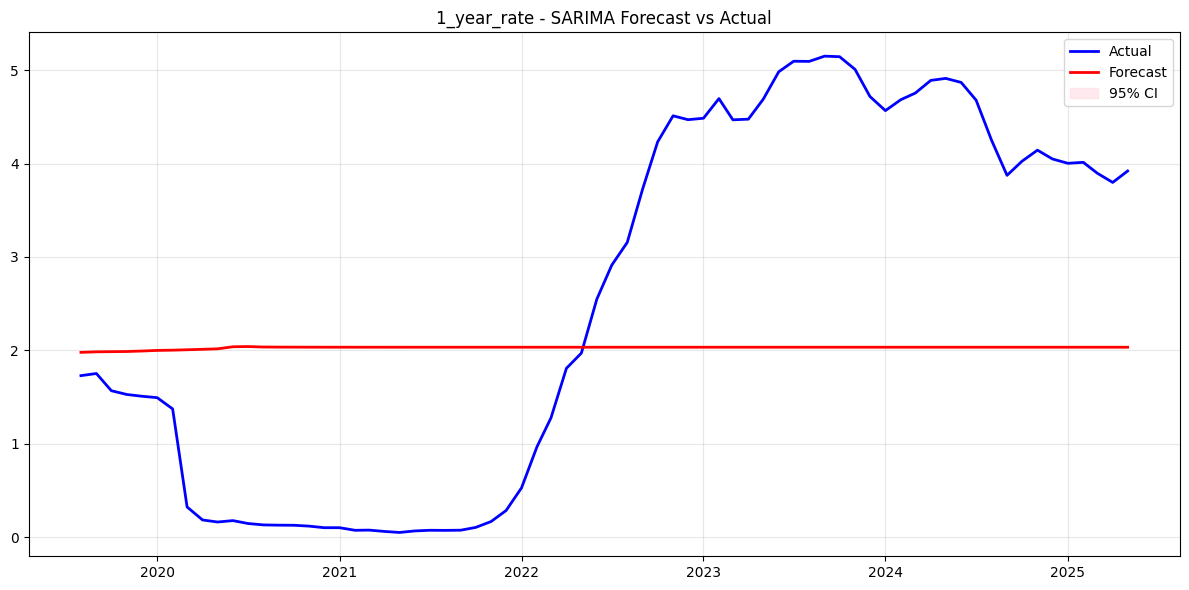


[2/12] Processing 3_months_rate

SARIMA Forecasting: 3_months_rate
📊 Initial NaN percentages: Train=0.0%, Test=0.0%
⚠️ Data frequency (MS) doesn't match expected (M), skipping frequency setting
✅ Final clean data: 630 train, 70 test rows
📈 Data statistics: Mean=4.7136, Std=3.3175
🔄 Auto-tuning SARIMA parameters...
✅ Optimal parameters: order=(0, 1, 1), seasonal_order=(0, 0, 1, 12)
🔄 Trying SARIMA(0,1,1)(0,0,1,12) [Attempt 1]
✅ Model fitted successfully
🧪 Test forecast std: 0.023946
🔍 Forecast diagnostics:
   • Forecast std: 0.011481
   • Forecast range: 0.081783
   • Actual test std: 2.1754
   • Std ratio (pred/actual): 0.0053
⚠️ WARNING: Forecast variation much smaller than actual variation
📊 Performance: MAE=2.0547, RMSE=2.2319, MAPE=1203.60%
✅ 3_months_rate completed successfully


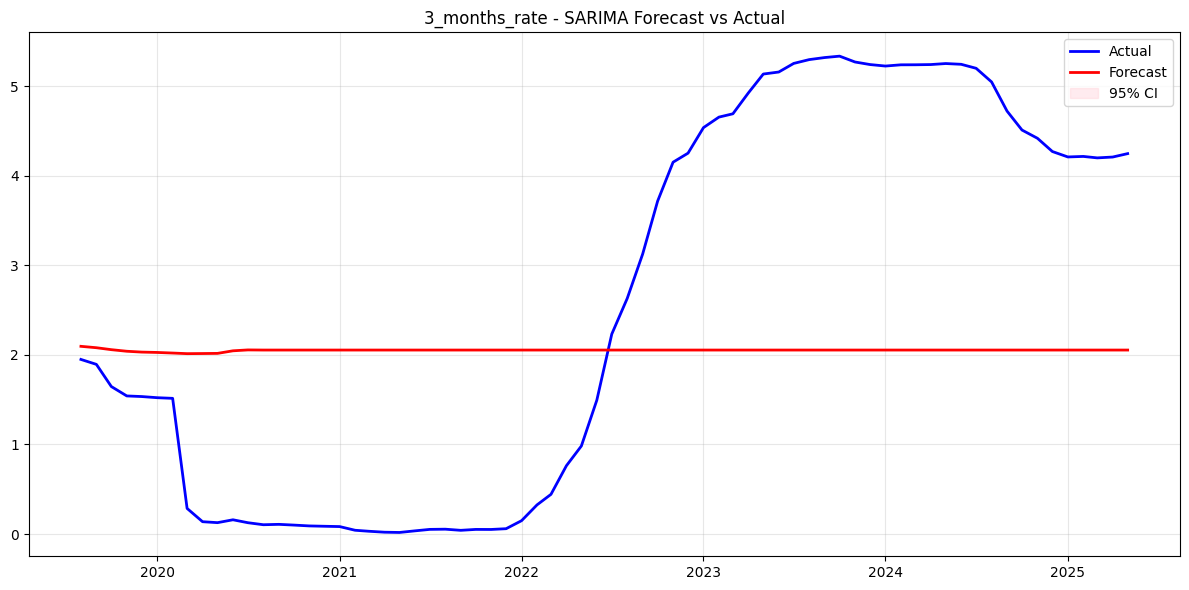


[3/12] Processing 6_months_rate

SARIMA Forecasting: 6_months_rate
📊 Initial NaN percentages: Train=0.0%, Test=0.0%
⚠️ Data frequency (MS) doesn't match expected (M), skipping frequency setting
✅ Final clean data: 630 train, 70 test rows
📈 Data statistics: Mean=4.8461, Std=3.3057
🔄 Auto-tuning SARIMA parameters...
✅ Optimal parameters: order=(0, 1, 1), seasonal_order=(1, 0, 1, 12)
🔄 Trying SARIMA(0,1,1)(1,0,1,12) [Attempt 1]
✅ Model fitted successfully
🧪 Test forecast std: 0.022025
🔍 Forecast diagnostics:
   • Forecast std: 0.009847
   • Forecast range: 0.075952
   • Actual test std: 2.1244
   • Std ratio (pred/actual): 0.0046
⚠️ WARNING: Forecast variation much smaller than actual variation
📊 Performance: MAE=2.0239, RMSE=2.2106, MAPE=830.69%
✅ 6_months_rate completed successfully


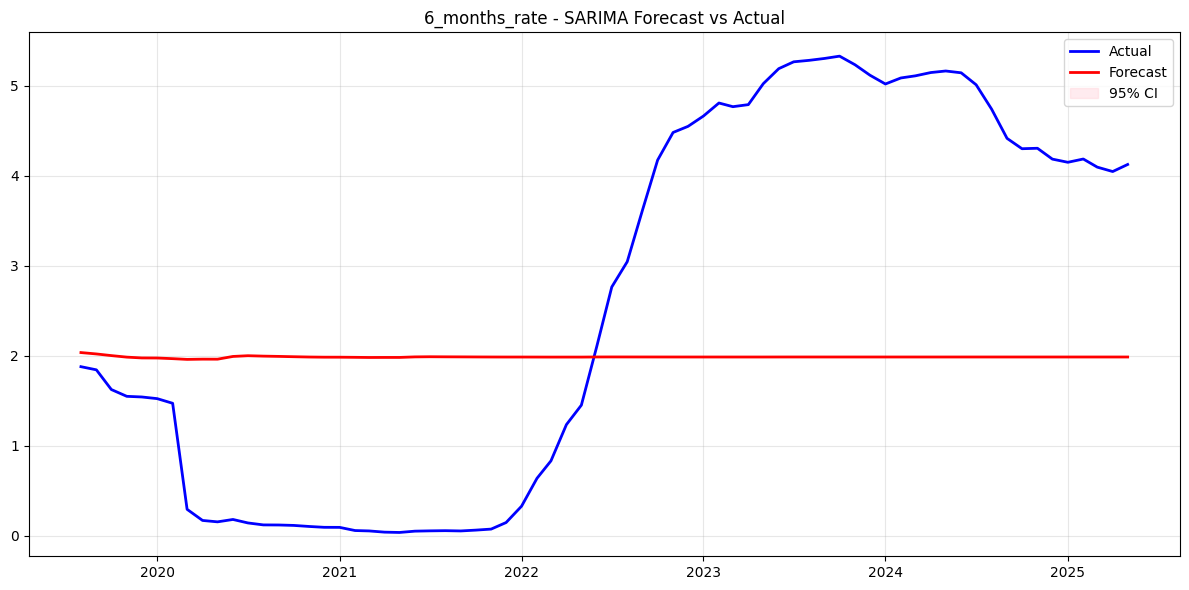


[4/12] Processing CPI

SARIMA Forecasting: CPI
📊 Initial NaN percentages: Train=0.0%, Test=0.0%
⚠️ Data frequency (MS) doesn't match expected (M), skipping frequency setting
✅ Final clean data: 630 train, 70 test rows
📈 Data statistics: Mean=140.4156, Std=68.6589
🔄 Auto-tuning SARIMA parameters...
✅ Optimal parameters: order=(0, 1, 2), seasonal_order=(0, 0, 1, 12)
🔄 Trying SARIMA(0,1,2)(0,0,1,12) [Attempt 1]
✅ Model fitted successfully
🧪 Test forecast std: 0.096616
🔍 Forecast diagnostics:
   • Forecast std: 0.082516
   • Forecast range: 0.465082
   • Actual test std: 22.6594
   • Std ratio (pred/actual): 0.0036
⚠️ WARNING: Forecast variation much smaller than actual variation
📊 Performance: MAE=31.5512, RMSE=38.7766, MAPE=10.39%
✅ CPI completed successfully


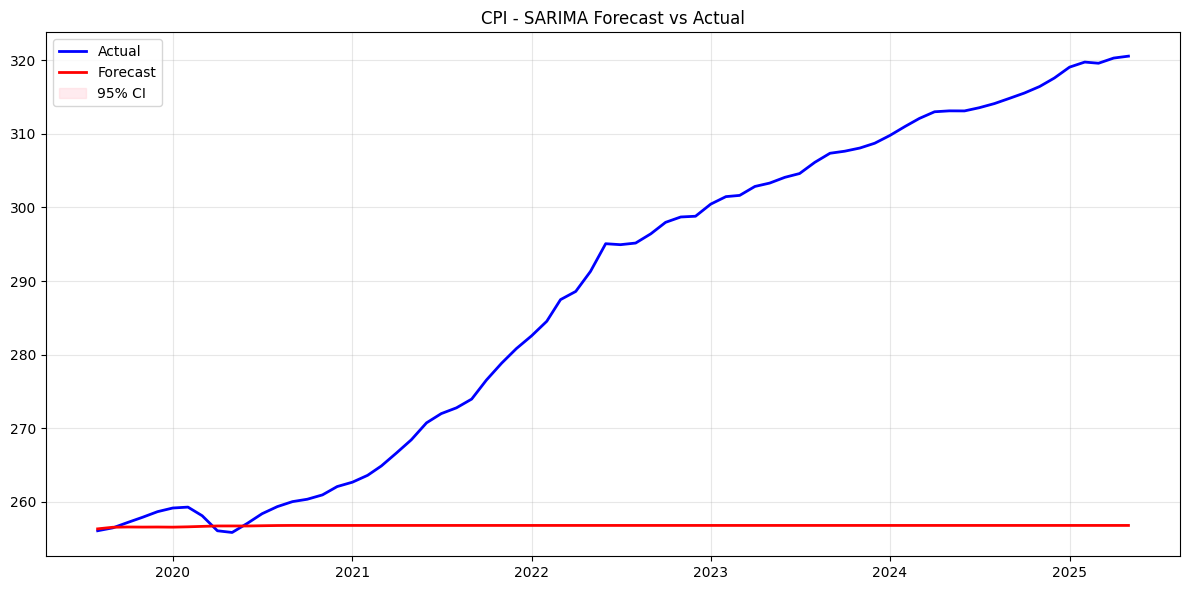


[5/12] Processing INDPRO

SARIMA Forecasting: INDPRO
📊 Initial NaN percentages: Train=0.0%, Test=0.0%
⚠️ Data frequency (MS) doesn't match expected (M), skipping frequency setting
✅ Final clean data: 630 train, 70 test rows
📈 Data statistics: Mean=70.5323, Std=22.9867
🔄 Auto-tuning SARIMA parameters...
✅ Optimal parameters: order=(2, 1, 2), seasonal_order=(1, 0, 1, 12)
🔄 Trying SARIMA(2,1,2)(1,0,1,12) [Attempt 1]
✅ Model fitted successfully
🧪 Test forecast std: 0.141669
🔍 Forecast diagnostics:
   • Forecast std: 0.118561
   • Forecast range: 0.634415
   • Actual test std: 3.6627
   • Std ratio (pred/actual): 0.0324
✅ Forecast has reasonable variation
📊 Performance: MAE=2.3611, RMSE=3.6971, MAPE=2.45%
✅ INDPRO completed successfully


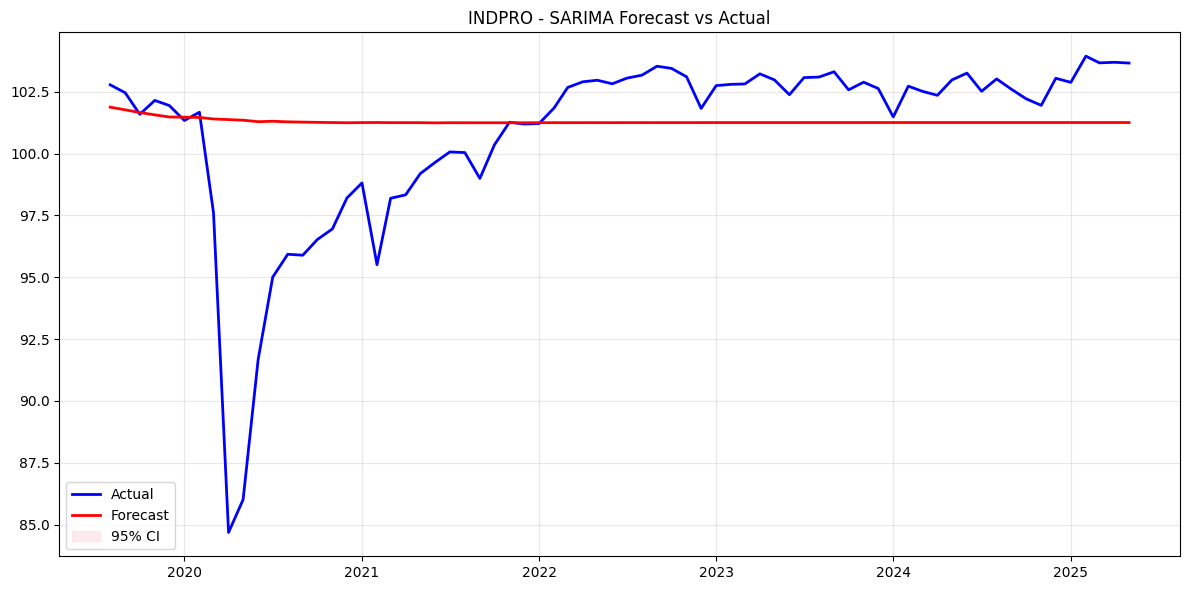


[6/12] Processing 10_year_rate

SARIMA Forecasting: 10_year_rate
📊 Initial NaN percentages: Train=0.0%, Test=0.0%
⚠️ Data frequency (MS) doesn't match expected (M), skipping frequency setting
✅ Final clean data: 630 train, 70 test rows
📈 Data statistics: Mean=6.3333, Std=2.9569
🔄 Auto-tuning SARIMA parameters...


KeyboardInterrupt: 

In [31]:
# Use the robust version instead
results = run_sarima_pipeline_robust(
    df=dim_reduced_df, 
    financial_indicators=financial_indicators,
    freq='M',  # or 'D', 'W' as appropriate
    auto_tune=True,
    plot_results=True
)